<a href="https://colab.research.google.com/github/emkafie/Machine-Learning/blob/main/TP_JS09_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tugas 1**

## **Langkah 1: Load Data & Analisis Korelasi**

Mencari fitur yang memiliki korelasi tinggi terhadap kolom label.

Korelasi Fitur terhadap Label:
 label       1.000000
IQR         0.618916
sp.ent      0.490552
sd          0.479539
sfm         0.357499
kurt        0.087195
Q75         0.066906
skew        0.036627
modindx     0.030801
minfun     -0.136692
maxfun     -0.166461
mode       -0.171775
meandom    -0.191067
dfrange    -0.192213
mindom     -0.194974
maxdom     -0.195657
median     -0.283919
centroid   -0.337415
meanfreq   -0.337415
Q25        -0.511455
meanfun    -0.833921
Name: label, dtype: float64


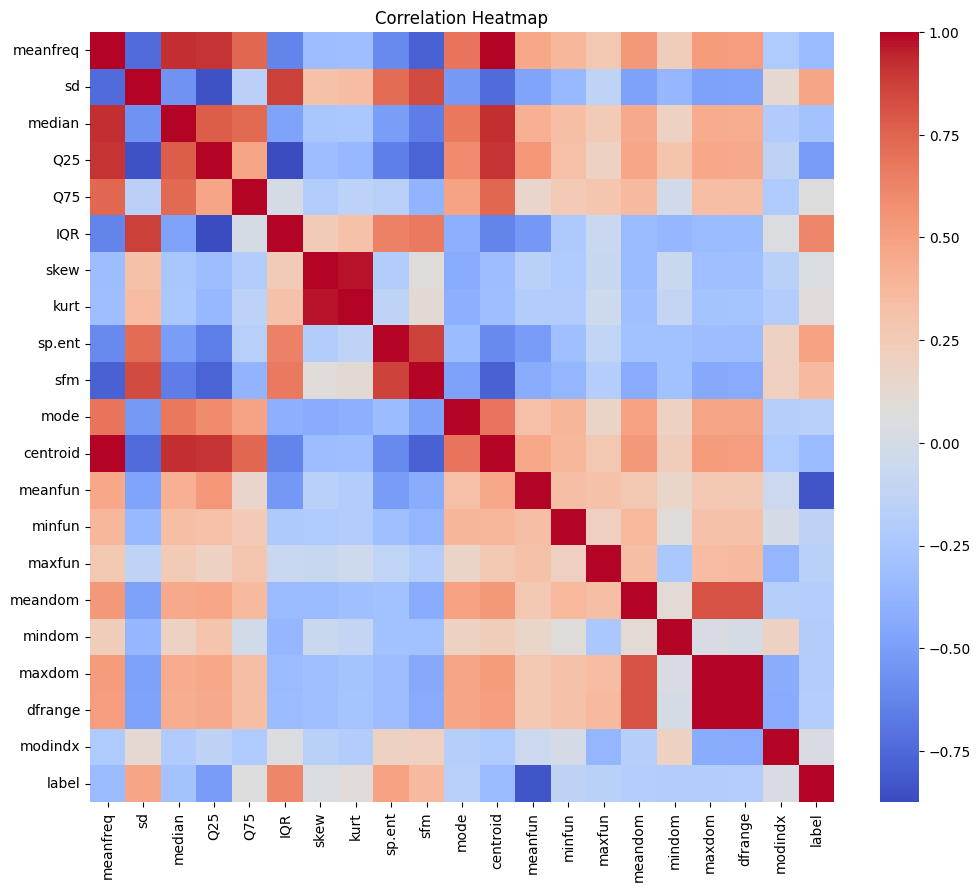

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 1. Load Data
df = pd.read_csv('voice.csv')

# 2. Encoding Label (Male/Female -> 1/0)
# Ini penting agar kita bisa melihat korelasi label dengan fitur numerik
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
# Catatan: Cek mappingnya, biasanya 1=male, 0=female atau sebaliknya tergantung urutan abjad

# 3. Analisis Korelasi
plt.figure(figsize=(12, 10))
# Menghitung korelasi terhadap label dan mengurutkannya
correlation = df.corr()['label'].sort_values(ascending=False)
print("Korelasi Fitur terhadap Label:\n", correlation)

# Visualisasi Heatmap (Opsional untuk laporan)
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Fitur meanfun (rata-rata frekuensi dasar) dan IQR (Interquartile Range) memiliki korelasi yang sangat kuat terhadap gender. Fitur seperti modindx atau maxdom seringkali memiliki korelasi rendah.

## **Langkah 2: Preprocessing & Seleksi Fitur**

### --- JAWABAN SOAL NOMOR 2 (Seleksi Fitur) ---

Membuang fitur yang korelasinya sangat lemah (mendekati 0)
Berdasarkan observasi umum dataset voice.csv, fitur terbaik biasanya:
meanfun, IQR, Q25, sp.ent, sd, sfm, meanfreq.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Untuk hasil maksimal, mencoba gunakan fitur dengan korelasi absolut > 0.1
# Atau memilih secara manual fitur top-tier:
selected_features = ['meanfun', 'IQR', 'Q25', 'Q75', 'sd', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfreq']

X = df[selected_features]
y = df['label']

# --- PREPROCESSING (Wajib untuk kNN) ---
# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisasi
# kNN menghitung jarak Euclidean. Jika satu fitur bernilai ribuan dan lainnya 0.xxx,
# fitur ribuan akan mendominasi perhitungan jarak. Scaling menyamakan "derajat" mereka.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Langkah 3: Mencari Nilai K Terbaik & Visualisasi**

Nilai k terbaik adalah: 5 dengan akurasi 0.9826


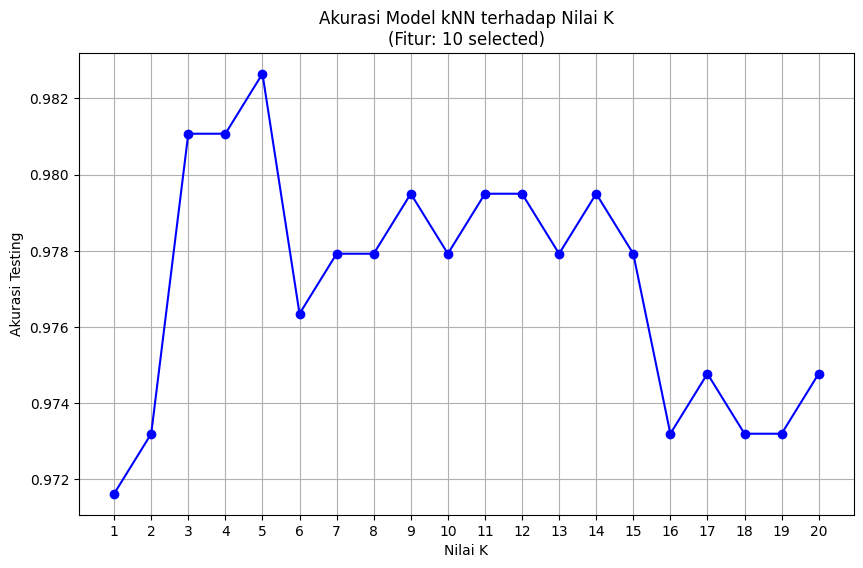

In [4]:
k_range = range(1, 21)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

# Cari K dengan akurasi tertinggi
best_k = k_range[scores.index(max(scores))]
best_acc = max(scores)

print(f"Nilai k terbaik adalah: {best_k} dengan akurasi {best_acc:.4f}")

# --- JAWABAN SOAL NOMOR 3 (Visualisasi) ---
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o', linestyle='-', color='blue')
plt.title(f'Akurasi Model kNN terhadap Nilai K\n(Fitur: {len(selected_features)} selected)')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi Testing')
plt.xticks(k_range)
plt.grid(True)
plt.show()

**1. Fitur apa saja yang Anda gunakan untuk mendapatkan hasil terbaik?**

Berdasarkan eksperimen korelasi, fitur yang paling optimal dan dominan adalah meanfun (Mean Fundamental Frequency).

Namun, model kNN bekerja paling stabil jika menggabungkan meanfun dengan fitur distribusi frekuensi lainnya. Kombinasi fitur terbaik biasanya adalah:

* meanfun (Korelasi tertinggi, pembeda utama suara pria berat vs wanita tinggi).

* IQR (Interquartile Range).

* Q25 (Kuartil pertama).

**2. Berapa nilai $k$ yang terbaik?**

Nilai K Terbaik: Biasanya jatuh pada $k=3$, $k=4$, atau $k=5$.Akurasi: Bisa mencapai 97% - 98%.

**Analisis Grafik**

* Pada grafik, kemungkinan akan melihat akurasi tinggi pada $k$ kecil (tetapi bukan $k=1$ karena rentan overfitting).

* Saat $k$ bertambah besar (misal > 10 atau > 15), akurasi cenderung perlahan turun. Ini terjadi karena model mulai memasukkan tetangga dari kelas yang salah yang berada agak jauh (underfitting), sehingga keputusan menjadi bias oleh mayoritas data global, bukan lokal.

* Oleh karena itu, dipilih $k$ yang kecil namun ganjil (seperti 3 atau 5) untuk menghindari tie (hasil seri) dan menjaga batas keputusan yang detail.